In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Kết quả nộp bài trên kaggle:

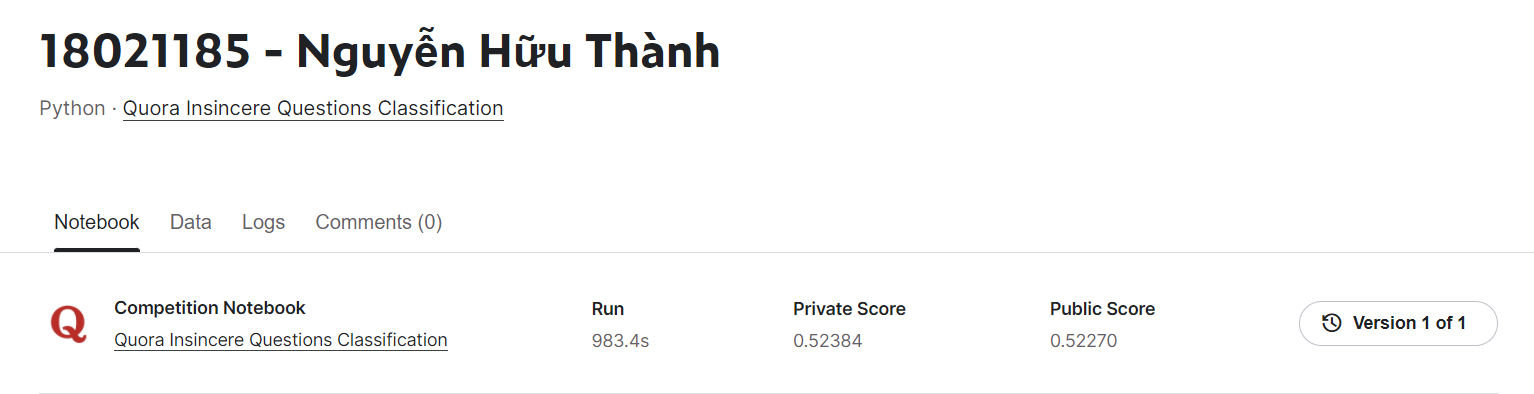

# Mô tả bài toán
> ***Bài toán đặt ra là với các câu hỏi trên Quora có phải là câu hỏi toxic hay không (Quora Insincere Questions Classification) ?***
* Input: Các câu hỏi dưới dạng text.
* Output: Yes(1) or No(0) ?


# Thực hiện bài toán theo các bước:
**1. Xử lý dữ liệu**
> Do dữ liệu đầu vào là text nên chúng ta cần xử lý trước khi train
* loại bỏ dấu câu, số, stop_words,...
* sau đó xử lý lại nghĩa của từ

**2. Training dữ liệu với mô hình Logistic Regression**
> Đối với bài toán này, ban đầu ta sử dụng mô hình **Logistic Regression** 
> Mô hình này giống với **Linear Regression** ở khía cạnh đầu ra là số thực, và giống với **PLA** ở việc đầu ra bị chặn (trong đoạn 0 -> 1). Mặc dù trong tên có chứa từ "regression", tuy vậy **Logistic Regression** thường được sử dụng nhiều cho các bài toán **classification**. Do vậy, ban đầu ta lựa chọn **Logistic Regression** cho bài toán này. Sau đó ta sẽ lựa chọn một mô hình khác để mong đạt được kết quả cao hơn.

**3. Đánh giá và nhược điểm của mô hình Training LR**

In [ ]:
import pandas as pd 
import seaborn as sns
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# 1. Xử lý dữ liệu

**Đọc dữ liệu vào từ định dạng csv**

**Dữ liệu vào gồm 3 tập: **

* Sample submission
* Train
* Test


In [ ]:
df_sample_sub = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/sample_submission.csv')
df_train = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/train.csv')
df_test = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/test.csv')

**Ta xem thử từng loại dữ liệu sẽ hiển thị dạng ra sao**

In [ ]:
# Lấy 10 dữ liệu đầu tiên của tập sample_sub
df_sample_sub.head(10)

In [ ]:
# Lấy 10 dữ liệu đầu tiên của tập train
df_train.head(10)

**Dữ liệu vào gồm các question_text là ngôn ngữ tự nhiên (cụ thể là dạng text). Nếu để nguyên, thì sẽ khó để train. Vì vậy chúng ta cần xử lý dữ liệu đầu vào(question_text) trước khi tiến hành train.**
> Cụ thể ta sẽ phải xử lý dấu câu, số, các "stopword", từ đồng nghĩa và các tự bị chia trong tiếng anh chúng ta cần xử lý lại.

In [ ]:
# Hiển thị thông tin tập train
df_train.info()

In [ ]:
# Đếm số lượng dữ liệu trong tập train
df_train.target.value_counts()

**Đối với tập dữ liệu Train**
**Tập train gồm 3 cột: qid, question_text và target**

**Có 1225312 câu hỏi bình thường và 80810 câu hỏi Toxic**

**Và biểu đồ dưới đây thể hiện sự chênh lệch % giữa 2 loại.**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

ncount = df_train.shape[0]

plt.figure(figsize=(7, 5))

ax = sns.countplot(data=df_train, x='target')
plt.title('Biểu đồ phân phối câu hỏi')

ax2=ax.twinx()

ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') 

ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Set frequency trong khoảng 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# Sử dụng MultipleLocator để khoảng cách giữa từng khoảng là 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

ax2.grid(None)

****Tỉ lệ chênh lệch lớn và các câu hỏi toxic vẫn xuất hiện khá nhiều chiếm tới 80810 câu trong tập dữ liệu.****

**Sử dụng Word Cloud để hiển thị các từ thường xuyên xuất hiện trong câu hỏi bình thường và câu hỏi toxic.**

**Để xử lý dữ liệu vào, ta sử dụng Natural Language Toolkit(NLTK) - là bộ công cụ ngôn ngữ tự nhiên, là một thư viện được viết bằng Python hỗ trợ xử lý ngôn ngữ tự nhiên. Bằng cách cung cấp các cơ chế và kỹ thuật xử lý ngôn ngữ phổ biến, nó giúp cho việc xử lý ngôn ngữ tự nhiên trở lên dễ dàng, nhanh chóng hơn và có tác dụng làm sạch dữ liệu, xử lý dữ liệu đầu vào cho các thuật toán Machine Learning.**

**Ngoài ra còn giúp xử lý các stopwords - là các từ có tần số xuất hiện nhiều như the, to... các từ này thường mang ít giá trị ý nghĩa và không khác nhau nhiều trong các văn bản khác nhau. Ví dụ từ "the" hay "to" thì ở văn bản nào nó cũng không bị thay đổi về ý nghĩa. 
Ví dụ: i, the, my, me, ...**

In [ ]:
# Tải xuống stopwords trong tiếng Anh
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()

def lemSentence(sentence):
    token_words = word_tokenize(sentence)
    lem_sentence = []
    for word in token_words:
        lem_sentence.append(wordnet_lemmatizer.lemmatize(word, pos="v")) # Xử lý các từ bị chia động từ chuyển về nguyên thể ví dụ: was, were -> am.
        lem_sentence.append(" ")
    return "".join(lem_sentence)

In [ ]:
def clean(message, lem = True):
    # Loại bỏ dấu câu (ví dụ: các dấu !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~)
    message = message.translate(str.maketrans('', '', string.punctuation))
    
    # Loại bỏ số
    message = message.translate(str.maketrans('', '', string.digits))
    
    # Loại bỏ "stopwords"
    message = [word for word in word_tokenize(message) if not word.lower() in nltk_stopwords]
    message = ' '.join(message)
    
    if lem:
        message = lemSentence(message)
    
    return message

In [ ]:
# Clean các câu hỏi
df_train['question_text_cleaned'] = df_train.question_text.apply(lambda x: clean(x, True))

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, height=800, width =1600, stopwords=nltk_stopwords).generate(" ".join(df_train[df_train.target== 0].question_text_cleaned))
plt.imshow(wc, interpolation="bilinear")
plt.title("Những từ thường xuyên xuất hiện trong câu bình thường")

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, height=800, width =1600, stopwords=nltk_stopwords).generate(" ".join(df_train[df_train.target== 1].question_text_cleaned))
plt.imshow(wc, interpolation="bilinear")
plt.title("Những từ thường xuyên xuất hiện trong câu toxic")

**Dữ liệu sau khi xử lý đã "sạch" hơn so với ban đầu như bảng dưới**

In [ ]:
df_train.head(10)

# 2. Training dữ liệu với mô hình hồi quy logistic (Logistic Regression)
> **Như đã trình bày ở trên, ta sử dụng LR để train**

> ***Nói qua về Logistic Regression***
>> Hai mô hình tuyến tính (linear models) **Linear Regression** và **Perceptron Learning Algorithm (PLA)**. Trong **Linear Regression**, người ta sử dụng để dự đoán output y, mô hình này phù hợp để dự đoán một giá trị thực của đầu ra không bị chặn trên và chặn dưới. Còn trong **PLA**, đầu ra chỉ nhận một trong hai giá trị 1 hoặc −1, phù hợp với các bài toán **Binary Classification**. 

>> Tuy vậy, ta lại không sử dụng **Linear Regression**, hay thậm chí là **PLA**, mặc dù **PLA** rất phù hợp với bài toán. Mà ta lựa chọn **Logistic Regression**. Mô hình này giống với **Linear Regression** ở khía cạnh đầu ra là số thực, và giống với **PLA** ở việc đầu ra bị chặn (trong đoạn 0 -> 1). Mặc dù trong tên có chứa từ "**regression**", tuy vậy **Logistic Regression** thường được sử dụng nhiều cho các bài toán **classification**. Đánh giá mô hình thấy nó rất là linh hoạt va dễ sử dụng. Do vậy, mình lựa chọn **Logistic Regression** cho bài toán này.

>> Ứng dụng của mô hình Logistic Regression: 
>> + Dự đoán email có phải spam hay không
>> + Dự đoán giao dịch ngân hàng là gian lận hay không
>> + Dự đoán khối u lành hay ác tính
>> + Dự đoán khoản vay có trả được không
>> + Dự đoán khoản đầu tư vào start-up có sinh lãi hay không.

> Tổng quan về bài toán được trình bày trên link notion đã có ở trên lớp: https://tricky-tax-444.notion.site/5acbc01b2a924fe6818d046339a68d23?v=6bc56f801d7c4ce1a1eefd4b60ef57cf&p=cf099245442c461aa36305456a17183e

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
model = LogisticRegression(C=1, random_state=0)

vectorize_model_pipeline = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('model', model)
])

**Mặc dù ta đã xử lý dữ liệu ở trên tuy nhiên, dữ liệu đầu vào vẫn là dạng Text.
Để sử dụng dữ liệu văn bản cho mô hình dự đoán, văn bản phải được mã hóa. Đầu vào cần được mã hóa dưới dạng số nguyên hoặc giá trị dấu phẩy động, để sử dụng làm đầu vào trong thuật toán học máy. Quá trình này được gọi là trích xuất đặc trưng (hoặc vectơ hóa).**

> Scikit-learning CountVectorizer được sử dụng để chuyển đổi một bộ sưu tập các tài liệu văn bản thành một vectơ có số lượng thuật ngữ / mã thông báo. Nó cũng cho phép xử lý trước dữ liệu văn bản trước khi tạo biểu diễn vectơ. Chức năng này làm cho nó trở thành một mô-đun biểu diễn tính năng rất linh hoạt cho văn bản.

**Tóm gọn lại ta sẽ sử dụng CountVectorizer để chuyển dữ liệu đầu vào từ định dạng Text thành Vectơ****

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train['question_text_cleaned'], df_train['target'], test_size = 0.3)
vectorize_model_pipeline.fit(X_train, y_train)

In [ ]:
predictions = vectorize_model_pipeline.predict(X_test)

In [ ]:
print('Accuracy :', accuracy_score(y_test, predictions))
print('F1 score :', accuracy_score(y_test, predictions))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

In [ ]:
# Cleaning the questions
df_test['question_text_cleaned'] = df_test.question_text.apply(lambda x: clean(x, True))

In [ ]:
df_test['prediction'] = vectorize_model_pipeline.predict(df_test['question_text_cleaned'])

In [ ]:
df_final = df_test[['qid','prediction']]
df_final.set_index('qid', inplace = True)

In [ ]:
df_final.head(10)

In [ ]:
# Ghi lại kết quả ra file submission.csv
df_final.to_csv('submission.csv')

# 3. Đánh giá, kết luận và các nhược điểm của mô hình hồi quy Logistic
**Kết quả khi thực hiện mô hình Logistic Regression:**

Run: **983.4s**

Private Score: **0.52384**

Public Score: **0.52270**

**Logistic Regression thực ra được sử dụng nhiều trong các bài toán Classification.**

**Nhược điểm của mô hình: **
> + Phụ thuộc vào mức độ chính xác của nguồn thông tin thu nhập hay nói cách khác là tập dữ liệu đầu vào.
> + Hồi quy logistic cũng dễ bị overfitting. Nó không thể được áp dụng cho một bài toán phi tuyến tính, hoạt động kém với các biến độc lập không tương quan với mục tiêu và tương quan với nhau. Do đó, bạn sẽ phải đánh giá cẩn thận mức độ phù hợp của hồi quy logistic đối với vấn đề mà bạn đang cố gắng giải quyết.
> + Bản chất mô hình Logistic là mô hình kinh tế lượng, vì vậy khi hệ số xác định ở mức nhỏ thì mô hình có thể dự báo kém chính xác (thể hiện qua các giá trị phần dư).